In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import itertools
from os import listdir
import uproot
import awkward as ak
from sklearn.model_selection import train_test_split

import matplotlib as mpl

from datetime import datetime
import subprocess
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model, Sequential
import os
import tensorflow as tf
import sys
import importlib
sys.path.append('/scratch/mjosef/Unfolding/omnifold')
from omnifold import DataLoader, MLP, SetStyle, HistRoutine, net, PET, omnifold
from of_transformer import block, embed, input_distributed, net_utils, of_transformer, pair_embed, sequence_trimmer 

from IPython.display import Image

os.environ['CUDA_VISIBLE_DEVICES']="2" #odslserv 0123 überprüfen
has_gpu=True

from pickle import dump

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="3"
    physical_devices = tf.config.list_physical_devices('GPU') 
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

2025-09-15 09:59:06.184773: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-15 09:59:06.203195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757923146.220985 1082302 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757923146.226555 1082302 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757923146.243957 1082302 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Horovod not found, will continue with single only GPUs.
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
TUnfold_incl_path = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/unfolding_SR_Bulk_Final_l_4j_incl_TUnfoldStandalone_OptionA_data_nonClosureAlternative.root'
TUnfold_incl_file = uproot.open(TUnfold_incl_path)

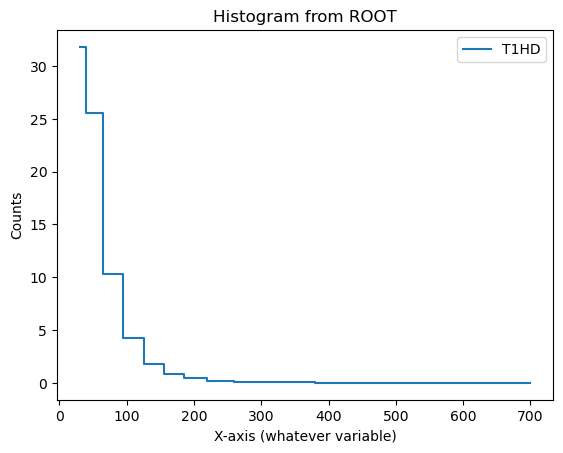

In [3]:
hist = TUnfold_incl_file['unfolding_ptl1_NOSYS']
values = hist.values()
edges = hist.axis().edges()  # for uproot v5+
# For uproot v4, use: edges = hist.axis().edges()

# Plot
plt.step(edges[:-1], values, where="mid", label="T1HD")
plt.xlabel("X-axis (whatever variable)")
plt.ylabel("Counts")
plt.title("Histogram from ROOT")
plt.legend()
plt.show()

In [4]:
#reco_herwig = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/ttbar_enhanced_Herwig71_fast.Nominal.root'
#truth_pythia = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/truth_ttbar_enhanced.Nominal.root'
#reco_pythia = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/ttbar_enhanced.Nominal.root'
#
#
#herwig_file = uproot.open(reco_herwig)
#herwig_tree = herwig_file['NOSYS/4j_incl']
#
#pythia_truth_file = uproot.open(truth_pythia)
#pythia_truth_tree = pythia_truth_file['NOSYS/physics']
#
#pythia_reco_file = uproot.open(reco_pythia)
#pythia_reco_tree = pythia_reco_file['NOSYS/4j_incl']
#pythia_matched_tree = pythia_reco_file['NOSYS/matched_4j_incl']

#herwig_array = herwig_tree.arrays()
#pythia_array = pythia_tree.arrays()

pythia_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_pythia_master.pkl')
herwig_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_herwig_master.pkl')
pythia_df["w2"] = pythia_df['eventWeight'].to_numpy()*pythia_df['eventWeight'].to_numpy()
herwig_df["w2"] = herwig_df['eventWeight'].to_numpy()*herwig_df['eventWeight'].to_numpy()
pythia_df.fillna(0.0, inplace=True)
herwig_df.fillna(0.0, inplace=True)


In [5]:
def MC_data_shaper(df):

    particle_names = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6']

    # Build reco and truth arrays
    reco_pts  = [df[f'pt{p}']   for p in particle_names]
    reco_etas = [df[f'eta{p}']  for p in particle_names]
    reco_phis = [df[f'phi{p}']  for p in particle_names]
    
    # Masses: lepton = 0, b-jets = mb1–4, jets = mj1–6
    reco_masses = [np.zeros_like(df['ptl1'])] + \
                  [df[f'mb{i}'] for i in range(1, 5)] + \
                  [df[f'mj{i}'] for i in range(1, 7)]
    # Stack into (12 particles, n_events, 4)
    reco_features = np.stack([reco_pts, reco_etas, reco_phis, reco_masses], axis=-1)
    reco_features = reco_features.transpose(1, 0, 2)  # → (n_events, 12, 4)

    # Neutrino (reco): met, eta=0, phi=metphi, mass=0
    met_pt = df['met']
    met_phi = df['metphi']
    zeros = np.zeros_like(met_pt)
    neutrino_reco = np.stack([met_pt, zeros, met_phi, zeros], axis=-1)  # (n_events, 4)

    # Append neutrino
    reco_features = np.concatenate([reco_features, neutrino_reco[:, None, :]], axis=1)  # (n_events, 12, 4)
    truth_pts  = [df[f'truth_pt{p}']   for p in particle_names]
    truth_etas = [df[f'truth_eta{p}']  for p in particle_names]
    truth_phis = [df[f'truth_phi{p}']  for p in particle_names]
    
    truth_masses = [np.zeros_like(df['truth_ptl1'])] + \
                   [df[f'truth_mb{i}'] for i in range(1, 5)] + \
                   [df[f'truth_mj{i}'] for i in range(1, 7)]

    truth_features = np.stack([truth_pts, truth_etas, truth_phis, truth_masses], axis=-1)
    truth_features = truth_features.transpose(1, 0, 2)

    # Neutrino (truth): use 'truth_met' and 'truth_met_phi'
    truth_met_pt = df['truth_met']
    truth_met_phi = df['truth_metphi']
    zeros_truth = np.zeros_like(truth_met_pt)
    neutrino_truth = np.stack([truth_met_pt, zeros_truth, truth_met_phi, zeros_truth], axis=-1)

    truth_features = np.concatenate([truth_features, neutrino_truth[:, None, :]], axis=1)
    
    return reco_features, truth_features

In [6]:
pythia_reco, pythia_truth = MC_data_shaper(pythia_df)
herwig_reco, herwig_truth = MC_data_shaper(herwig_df)

pythia_weights = pythia_df['eventWeight'].to_numpy()
herwig_weights = herwig_df['eventWeight'].to_numpy()

pythia_pass_reco = pythia_df['pass_reco'].to_numpy()
pythia_pass_gen = pythia_df['pass_particle'].to_numpy()

herwig_pass_reco = herwig_df['pass_reco'].to_numpy()
herwig_pass_gen = herwig_df['pass_particle'].to_numpy()

In [7]:
all_indices_pythia = np.arange(len(pythia_reco))
np.random.seed(42)  # reproducibility
np.random.shuffle(all_indices_pythia)

# First random sample
random_indices_pythia_1 = all_indices_pythia[:2_000_000]
# Second, independent (non-overlapping) sample
random_indices_pythia_2 = all_indices_pythia[2_000_000:4_000_000]

# First Pythia sample
pythia_reco_train    = pythia_reco[random_indices_pythia_1]
pythia_truth_train   = pythia_truth[random_indices_pythia_1]
pythia_weights_train = pythia_weights[random_indices_pythia_1]
pythia_pass_reco_train = pythia_pass_reco[random_indices_pythia_1]
pythia_pass_gen_train = pythia_pass_gen[random_indices_pythia_1]

# Second Pythia sample
pythia_reco_test    = pythia_reco[random_indices_pythia_2]
pythia_truth_test   = pythia_truth[random_indices_pythia_2]
pythia_weights_test = pythia_weights[random_indices_pythia_2]
pythia_pass_reco_test = pythia_pass_reco[random_indices_pythia_2]
pythia_pass_gen_test = pythia_pass_gen[random_indices_pythia_2]

# First Herwig sample
random_indices_herwig = np.random.choice(len(herwig_reco), size=2_000_000, replace=False)
herwig_reco_train   = herwig_reco[random_indices_herwig]
herwig_truth_train   = herwig_truth[random_indices_herwig]
herwig_weights_train = herwig_weights[random_indices_herwig]
herwig_pass_reco_train = herwig_pass_reco[random_indices_herwig]
herwig_pass_gen_train = herwig_pass_gen[random_indices_herwig]

In [8]:
herwig_loader = DataLoader(reco = herwig_reco_train, gen = herwig_truth_train, weight = herwig_weights_train,
                           pass_reco = herwig_pass_reco_train, pass_gen = herwig_pass_gen_train,
                           normalize=True, normalization_factor = np.sum(herwig_weights_train))

pythia_loader = DataLoader(reco = pythia_reco_train, gen = pythia_truth_train, weight = pythia_weights_train,
                           pass_reco = pythia_pass_reco_train, pass_gen = pythia_pass_gen_train,
                           normalize=True, normalization_factor = np.sum(pythia_weights_train))


INFO: Normalizing sum of weights to 344360.3125 ...
INFO: Normalizing sum of weights to 187890.203125 ...


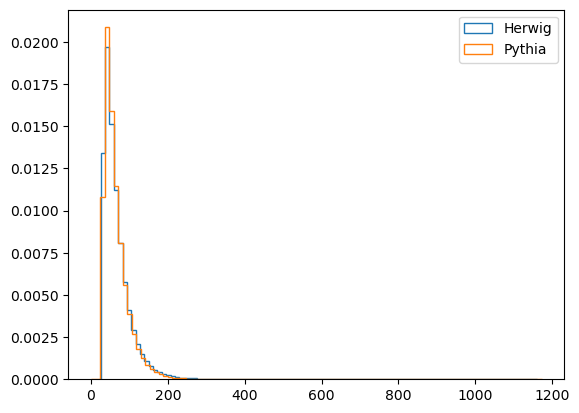

In [9]:
plt.hist(herwig_loader.gen[:,0,0], weights=herwig_loader.weight, bins=100, histtype='step',density=True, label='Herwig')
plt.hist(pythia_loader.gen[:,0,0], weights=pythia_loader.weight, bins=100, histtype='step',density=True, label='Pythia')
plt.legend()
#plt.yscale('log')
plt.show()

(<Figure size 900x900 with 2 Axes>,
 <Axes: ylabel='Normalized number of events'>)

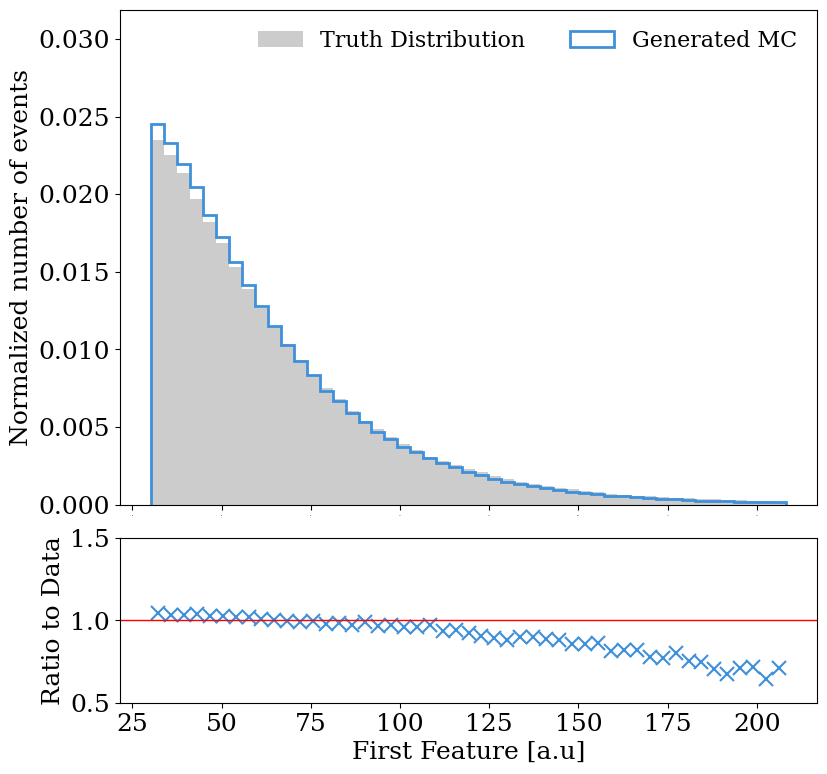

In [10]:
SetStyle()
data_dict = {
    'Truth Distribution': herwig_loader.gen[:,0,0],
    #'Reconstructed Data': herwig_loader.reco[:,0,0],
    'Generated MC': pythia_loader.gen[:,0,0],
    #'Reconstructed MC': pythia_loader.reco[:,0,0],
}
weight_dict = {
        'Truth Distribution': herwig_loader.weight,
        #'Reconstructed Data': herwig_loader.weight,
        'Generated MC': pythia_loader.weight,
        #'Reconstructed MC': pythia_loader.weight,
}
HistRoutine(data_dict,'First Feature [a.u]', reference_name = 'Truth Distribution', weights=weight_dict,plot_ratio=True)

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

class MaskedAveragePooling(layers.Layer):
    def call(self, x, mask):
        # x: (batch, seq_len, features)
        # mask: (batch, seq_len), dtype bool
        mask = tf.cast(mask, tf.float32)[..., tf.newaxis]  # (batch, seq_len, 1)
        x = x * mask
        return tf.reduce_sum(x, axis=1) / tf.reduce_sum(mask, axis=1)

class ParticleMaskLayer(layers.Layer):
    def call(self, x):
        return tf.reduce_any(tf.not_equal(x, 0), axis=-1)  # shape: (batch, seq)

def build_transformer_model(input_shape=(12, 4),
                            num_heads=4,
                            ff_dim=64,
                            num_transformer_blocks=2,
                            dropout_rate=0.1):

    inputs = Input(shape=input_shape)

    # Get attention mask: True where not padded
    mask = ParticleMaskLayer()(inputs)  # shape: (batch, 11)

    # Learned positional embedding
    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    pos_embed = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(positions)
    x = inputs + pos_embed  # broadcasting position embedding

    for _ in range(num_transformer_blocks):
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=input_shape[1]
        )(x, x, attention_mask=mask[:, tf.newaxis, :])  # shape: (batch, 1, 11)

        attn_output = layers.Dropout(dropout_rate)(attn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

        ff_output = layers.Dense(ff_dim, activation='relu')(x)
        ff_output = layers.Dense(input_shape[1])(ff_output)
        ff_output = layers.Dropout(dropout_rate)(ff_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

    # Use masked average pooling instead of GlobalAveragePooling1D
    x = MaskedAveragePooling()(x, mask)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=outputs)

In [12]:
model1 = build_transformer_model()
model2 = build_transformer_model()

I0000 00:00:1757923991.049031 1082302 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 140838 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:43:00.0, compute capability: 9.0


In [13]:
importlib.reload(omnifold)

Horovod not found, will continue with single only GPUs.


<module 'omnifold.omnifold' from '/scratch/mjosef/Unfolding/omnifold/omnifold/omnifold.py'>

In [14]:
omnifold = omnifold.MultiFold(
    "WWbb_transformer_bulk_closure",
    model1,
    model2,
    herwig_loader,
    pythia_loader,
    batch_size = 128,
    niter = 4,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = '/scratch/mjosef/Unfolding/omnifold/weights_transformer_bulk_closure',
    verbose = True,
    lr = 5e-5,
)

31250 training steps at reco and 31250 steps at gen


In [15]:
%%time
omnifold.Unfold()

ITERATION: 1
RUNNING STEP 1


Creating cached data from step 1
################################################################################
Train events used: 1391733, Test events used: 347934
################################################################################
Epoch 1/100


I0000 00:00:1757924000.958399 1085531 service.cc:152] XLA service 0x7fbf88002e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757924000.958443 1085531 service.cc:160]   StreamExecutor device (0): NVIDIA H200, Compute Capability 9.0
2025-09-15 10:13:21.094168: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1757924001.859320 1085531 cuda_dnn.cc:529] Loaded cuDNN version 90501


  78/8698 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.0733 

I0000 00:00:1757924009.246347 1085531 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8698/8698 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.0738 - val_loss: 0.0737 - learning_rate: 5.0000e-05
Epoch 2/100
8698/8698 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.0737 - val_loss: 0.0737 - learning_rate: 5.0000e-05
Epoch 3/100
8698/8698 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.0737 - val_loss: 0.0737 - learning_rate: 5.0000e-05
Epoch 4/100
8698/8698 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.0738 - val_loss: 0.0736 - learning_rate: 5.0000e-05
Epoch 5/100
8698/8698 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0737 - val_loss: 0.0736 - learning_rate: 5.0000e-05
Epoch 6/100
8698/8698 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0736 - val_loss: 0.0736 - learning_rate: 5.0000e-05
Epoch 7/100
8698/8698 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0737 - val_loss: 0.0736 - learning_rate: 5.0000e-05
Epoch 8/100
8698/8698 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.0735 - val_loss: 0.0736 - learning_rate: 5.0000e-05
Epoch 9/100
8698/8698 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 0.07

In [16]:
unfolded_weights  = omnifold.reweight(pythia_truth_test,omnifold.model2,batch_size=1000)

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  


In [17]:
np.save("/scratch/mjosef/Unfolding/omnifold/weights_transformer_bulk_closure/unfolded_weights.npy", unfolded_weights)

In [ ]:
#unfolded_weights = np.load("/scratch/mjosef/Unfolding/omnifold/weights_transformer_bulk_closure/unfolded_weights.npy")

/scratch/mjosef/Unfolding/omnifold/omnifold/utils.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(9, 9))


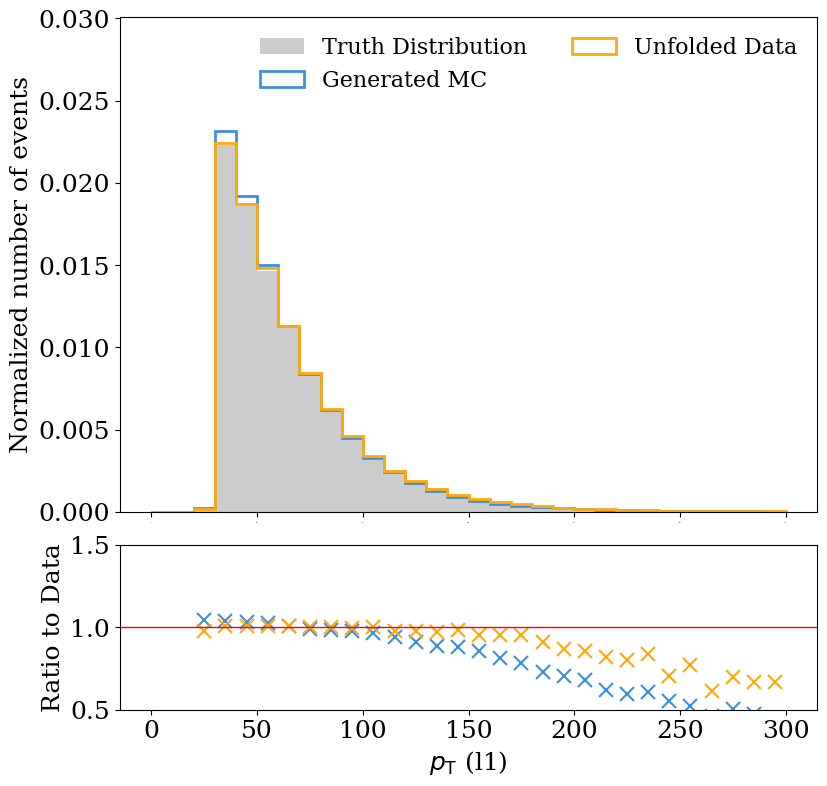

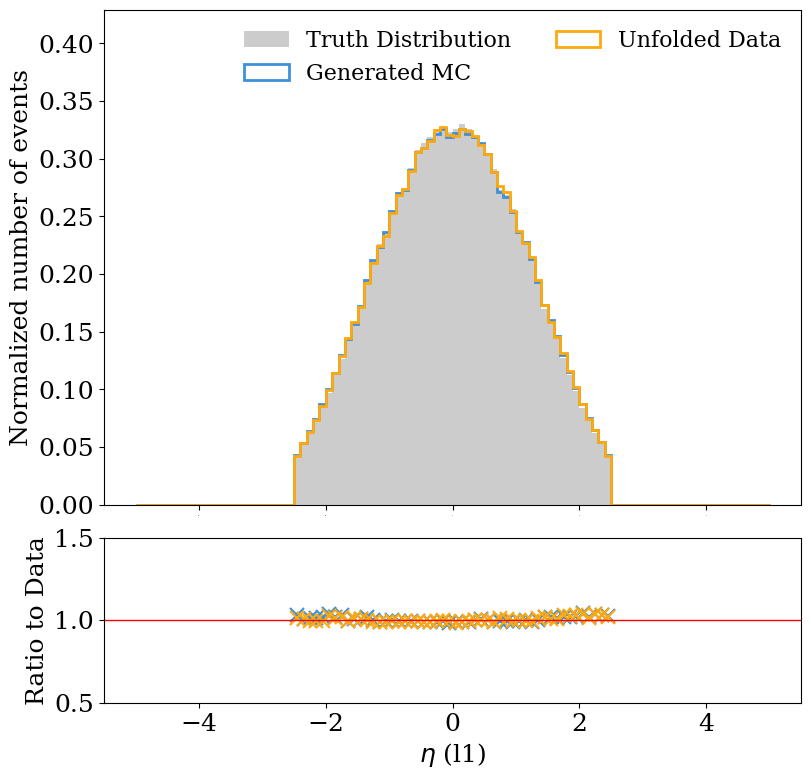

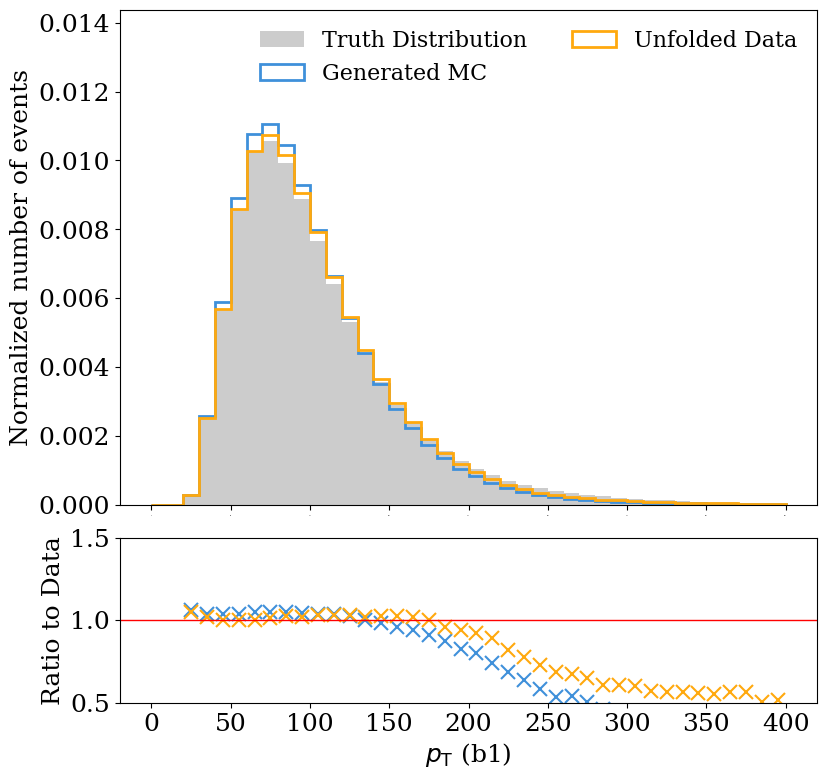

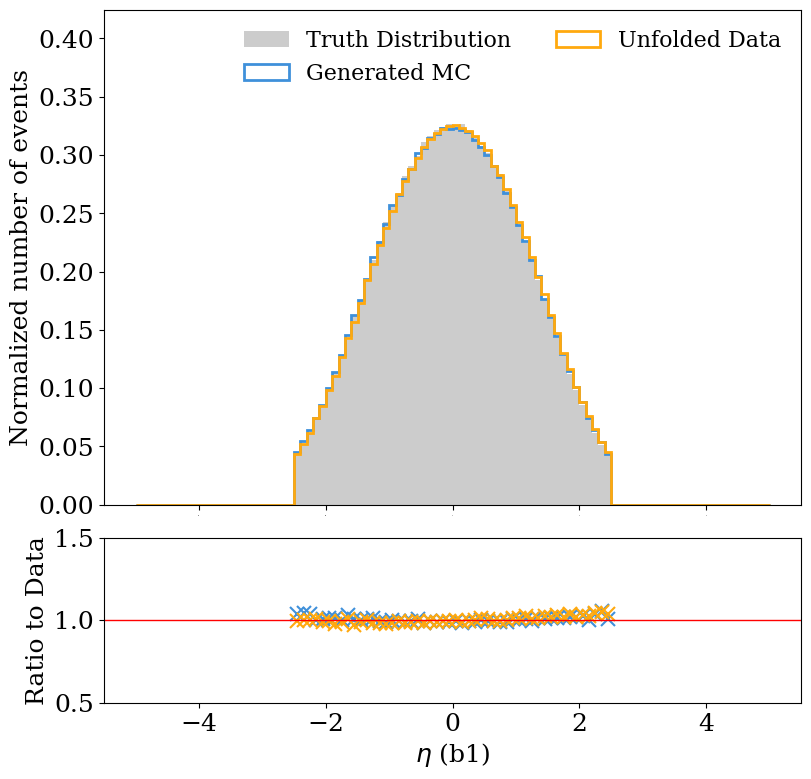

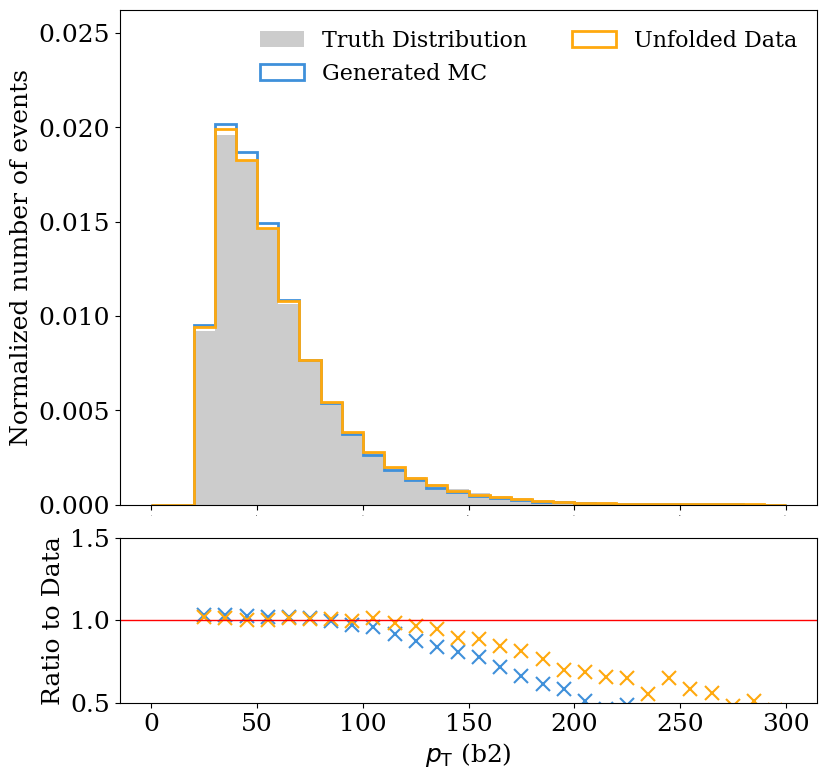

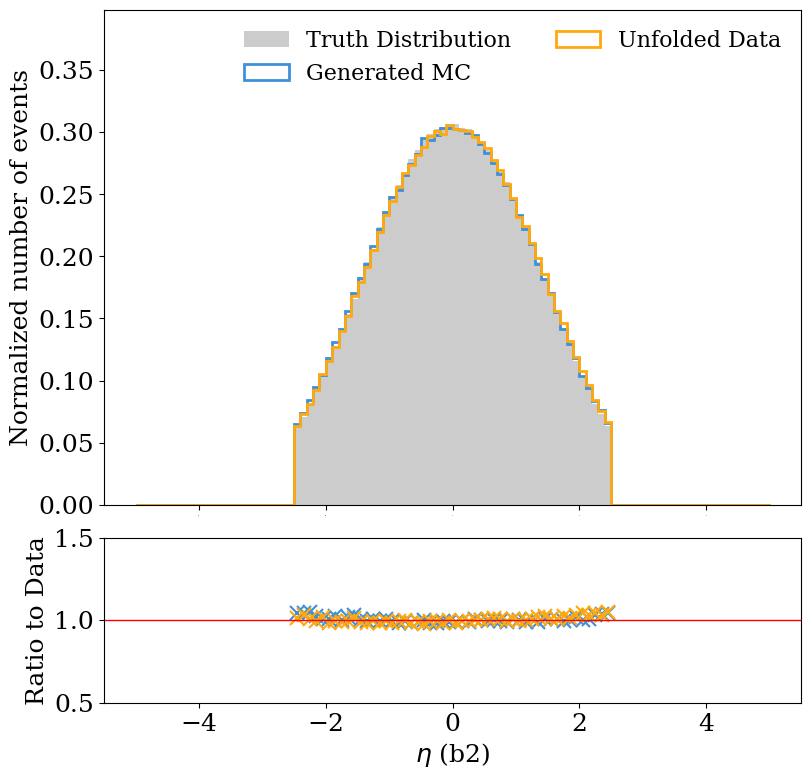

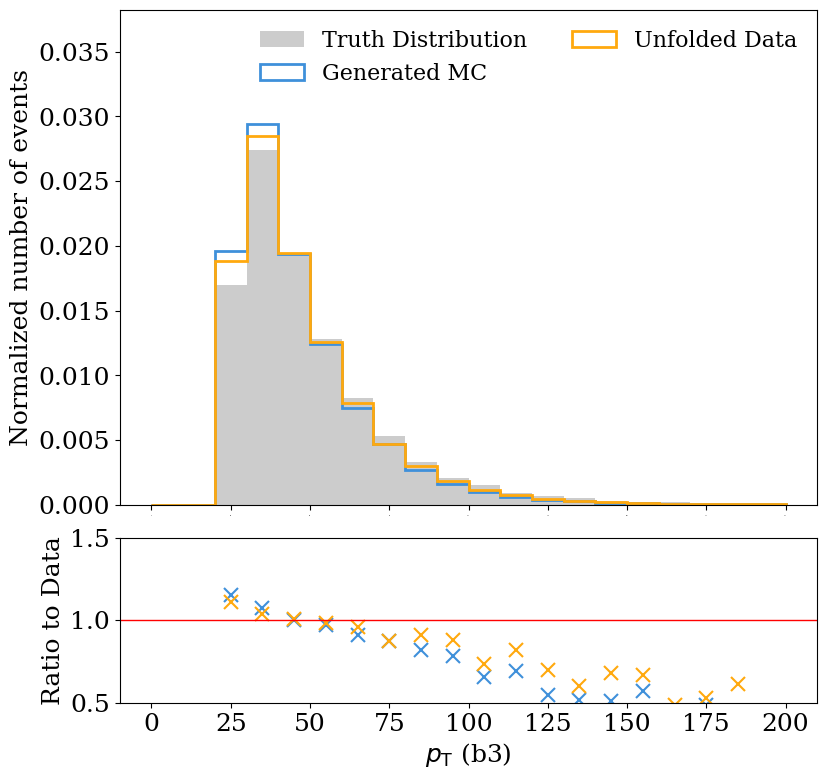

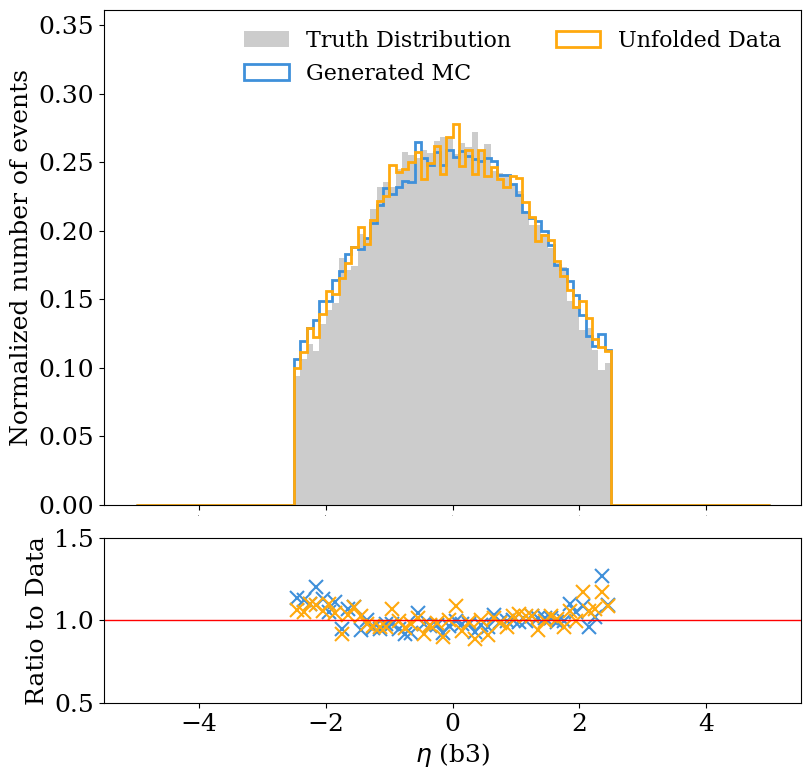

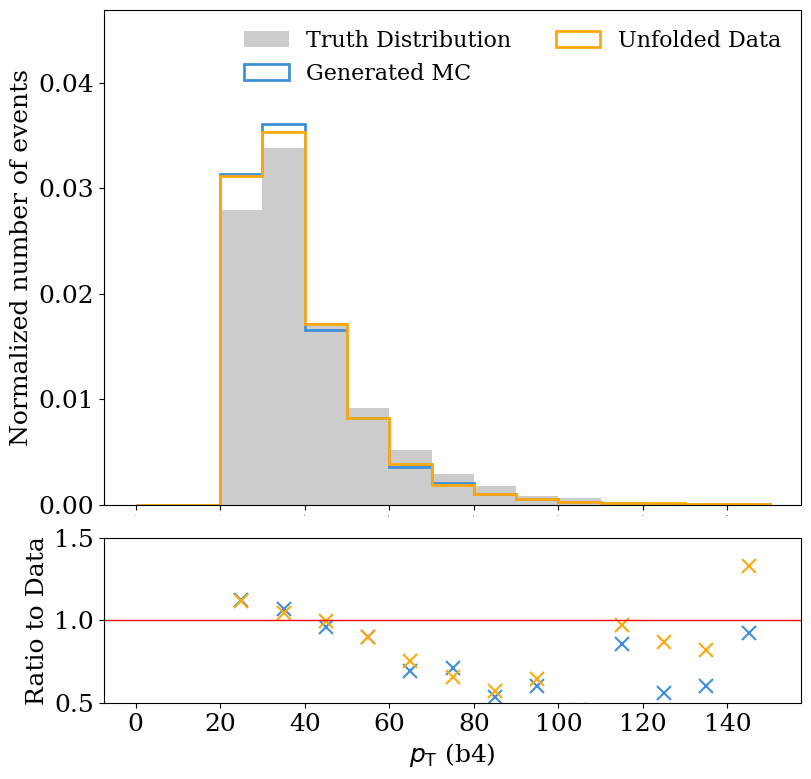

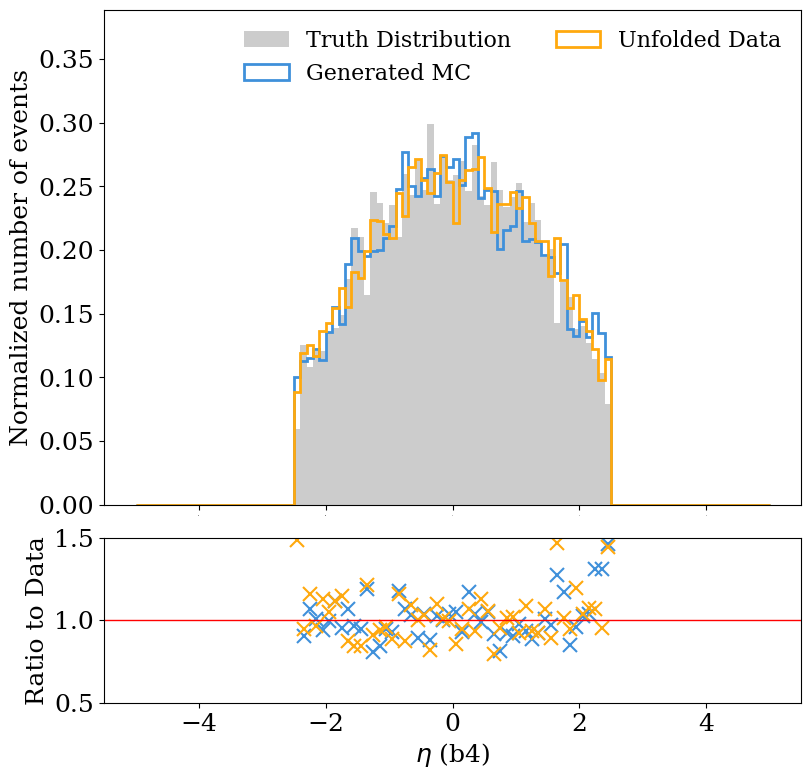

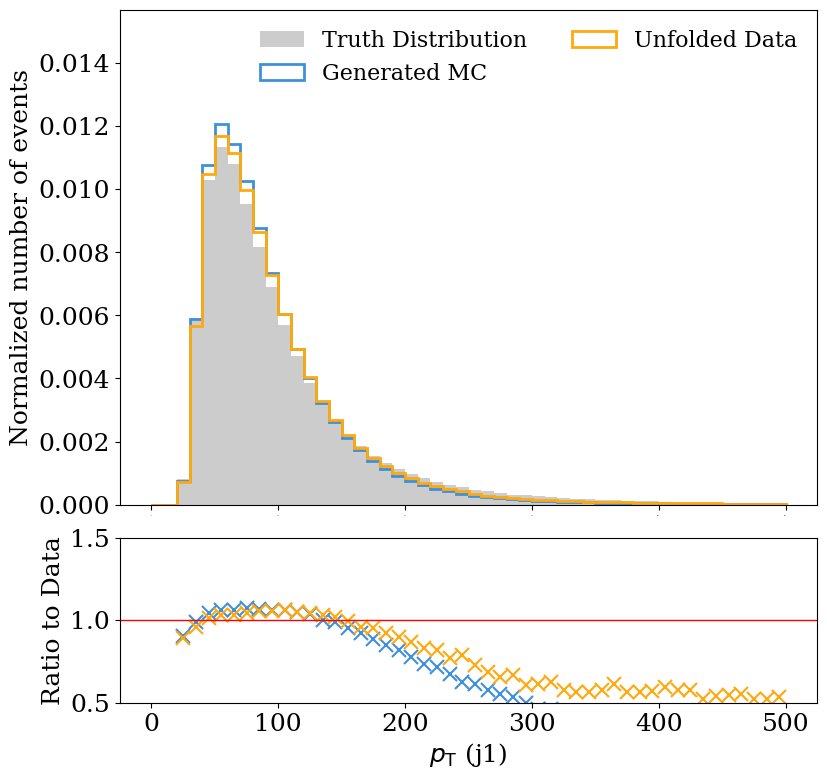

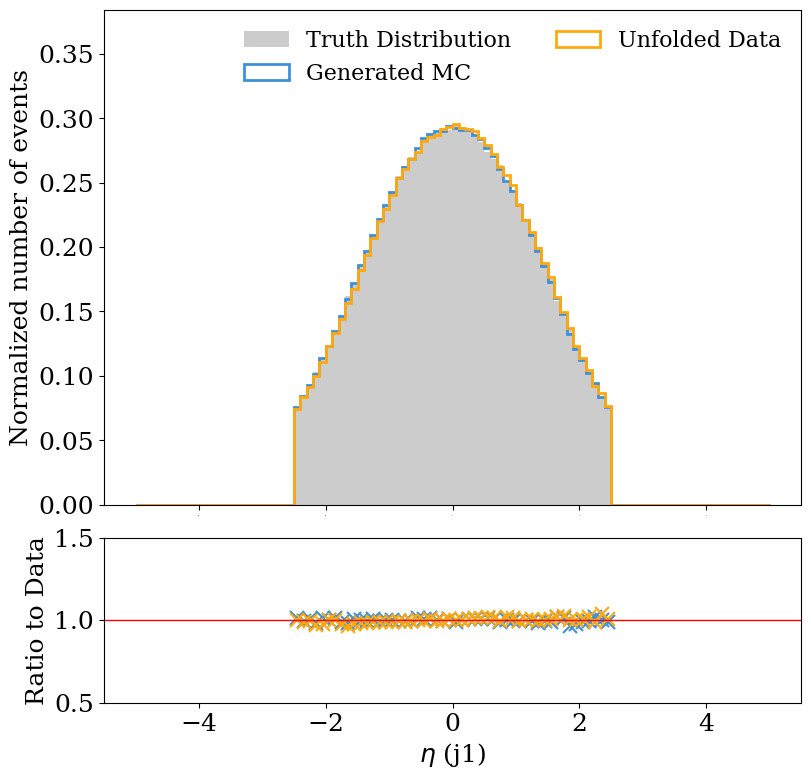

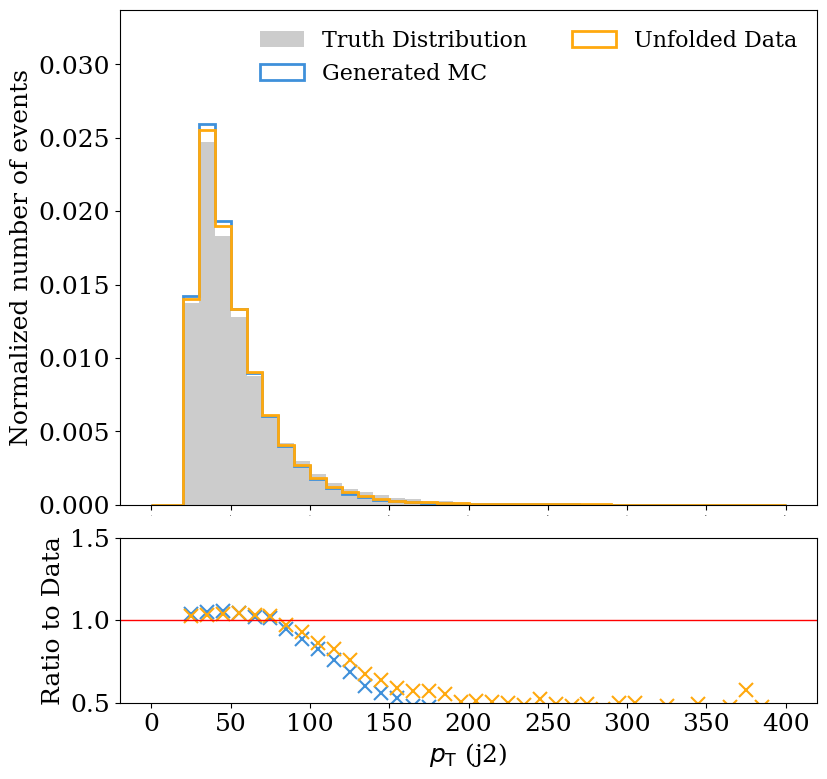

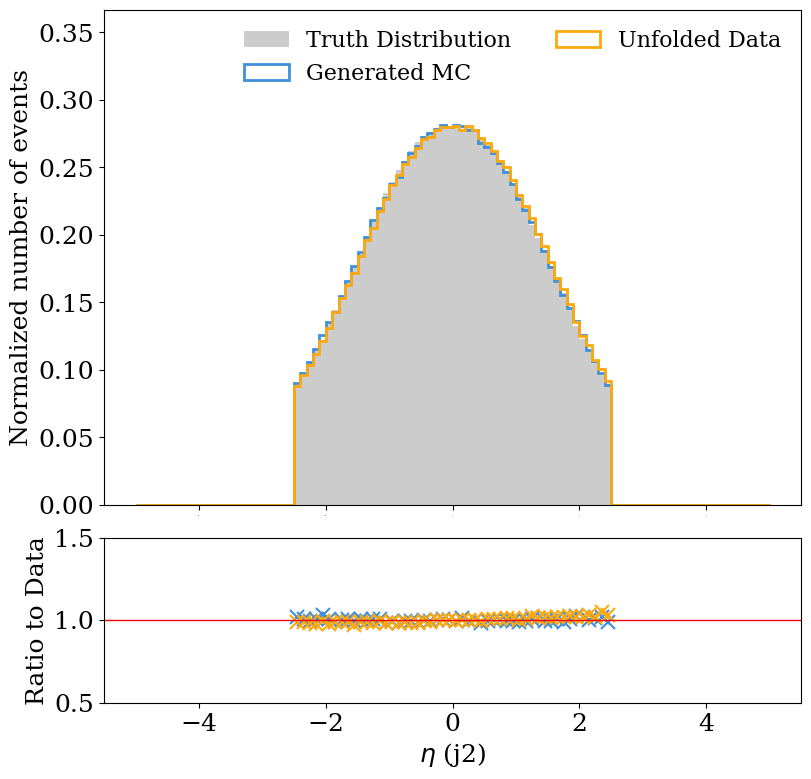

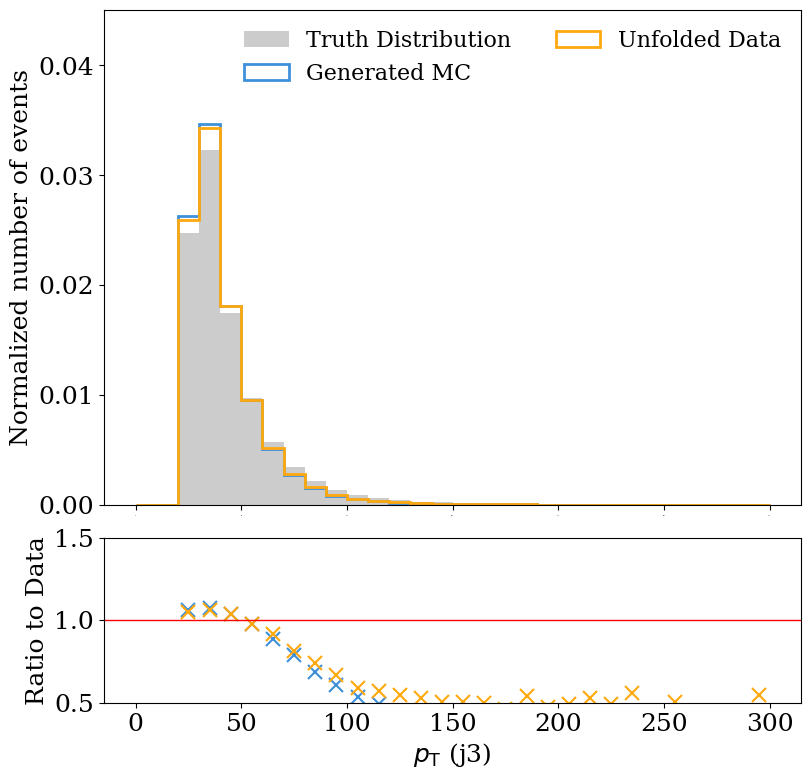

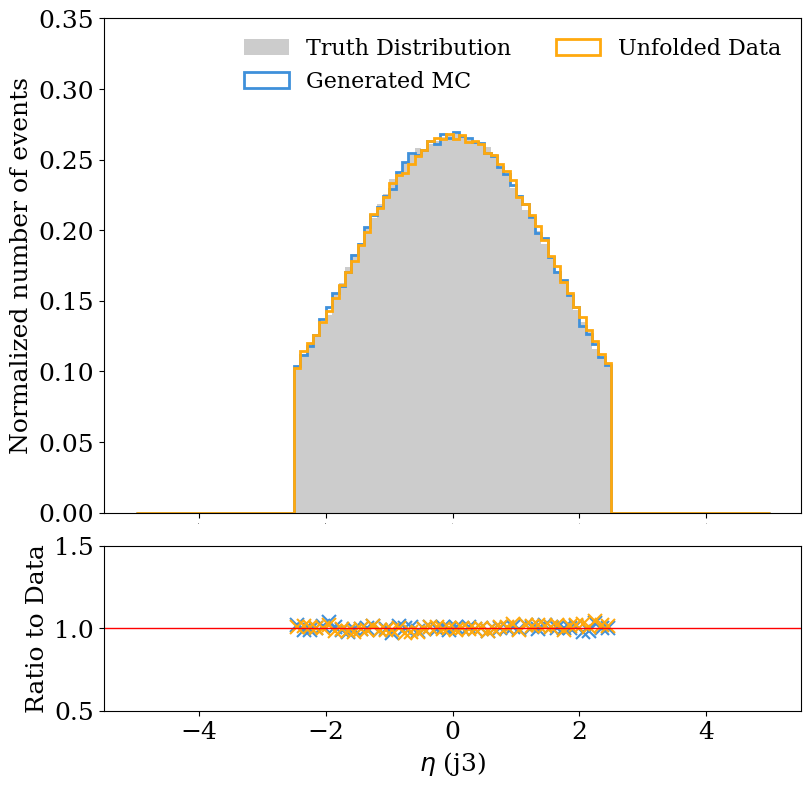

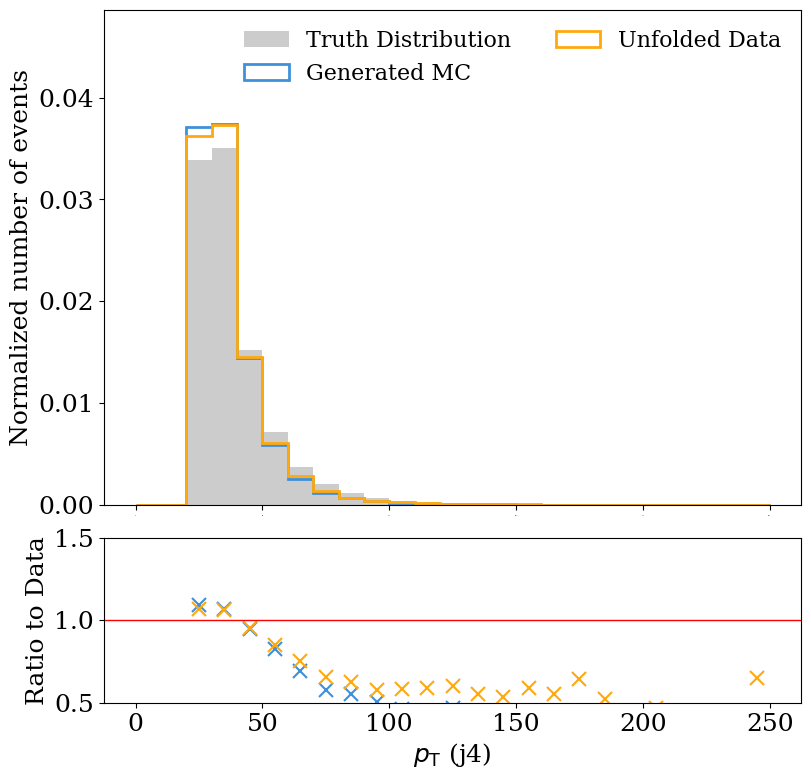

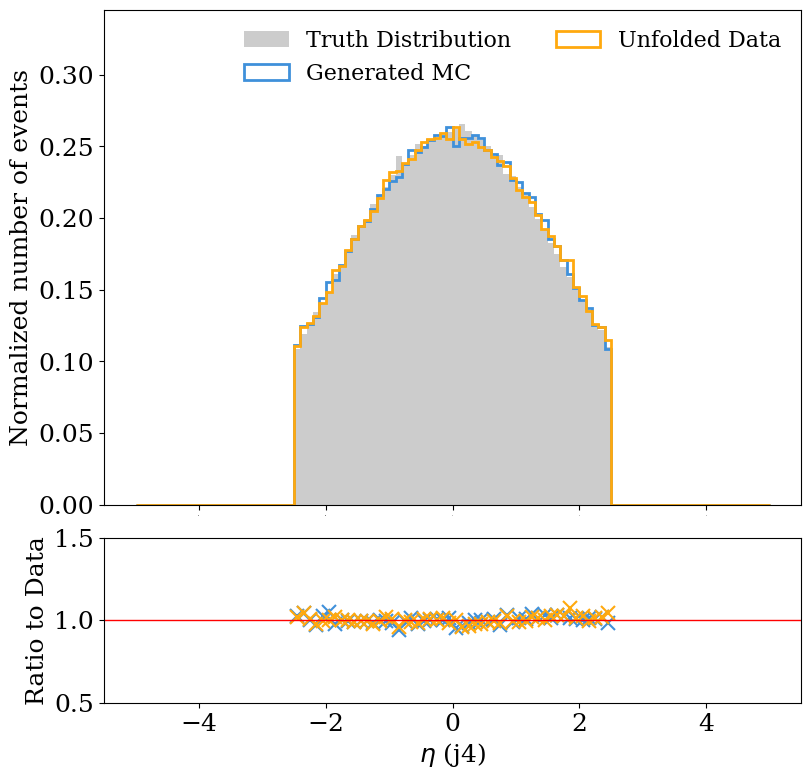

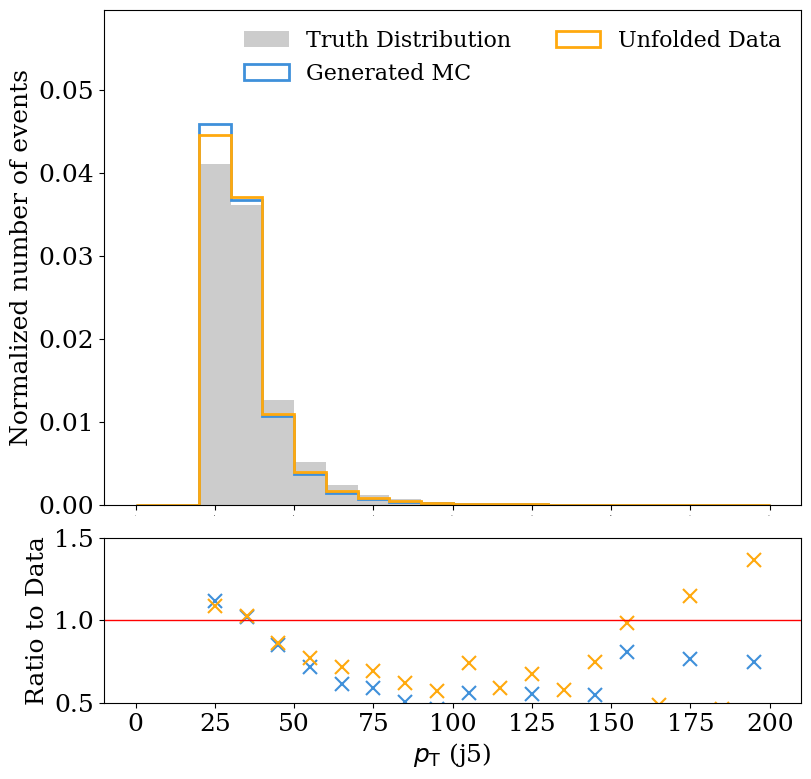

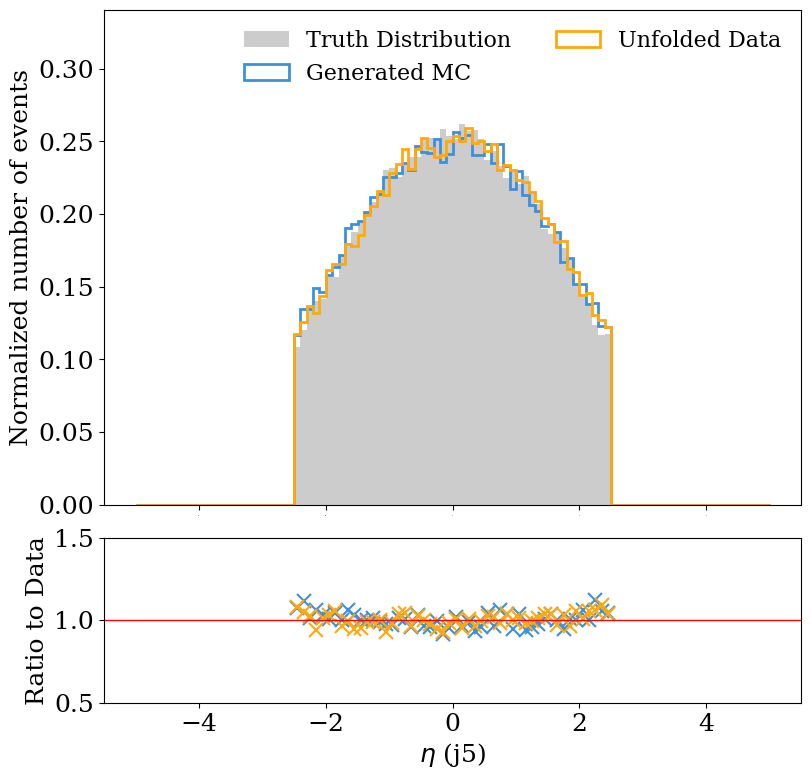

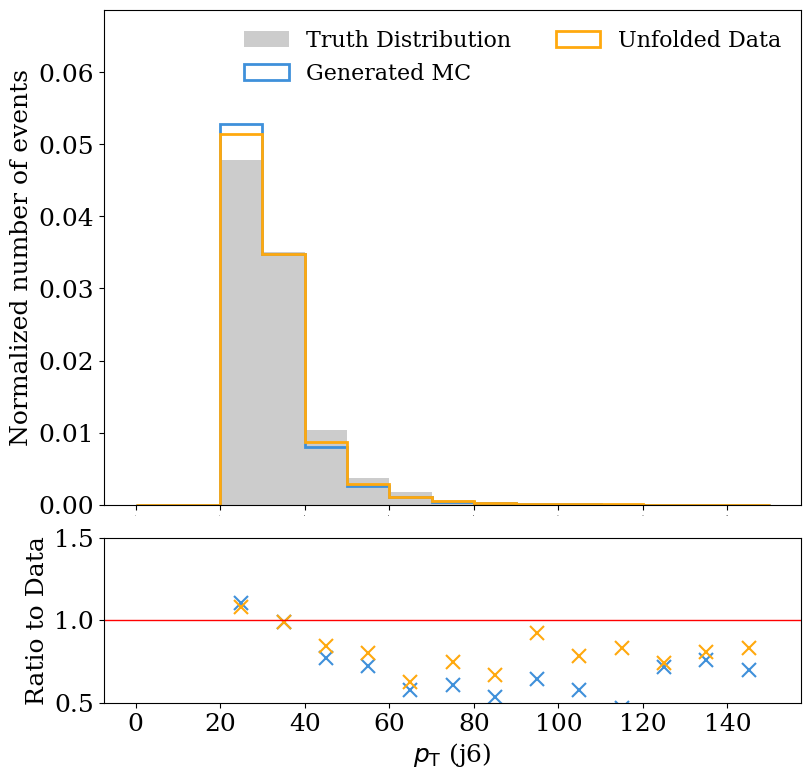

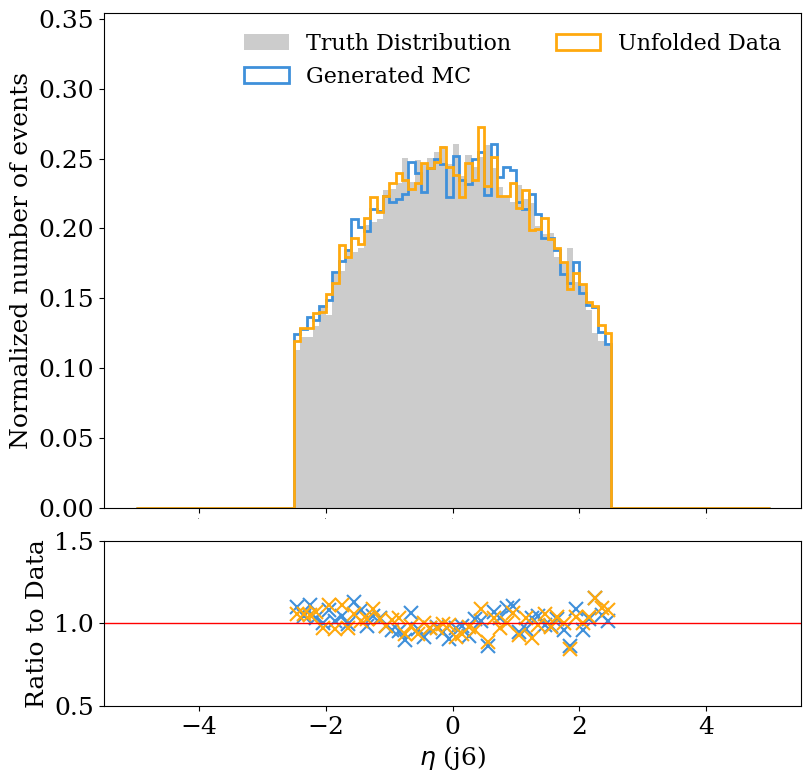

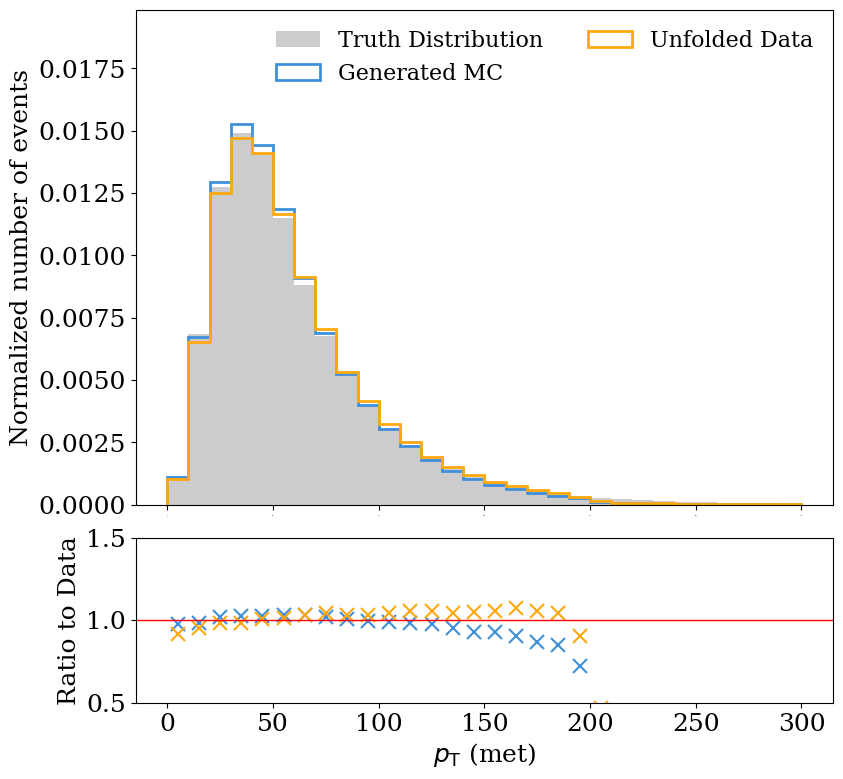

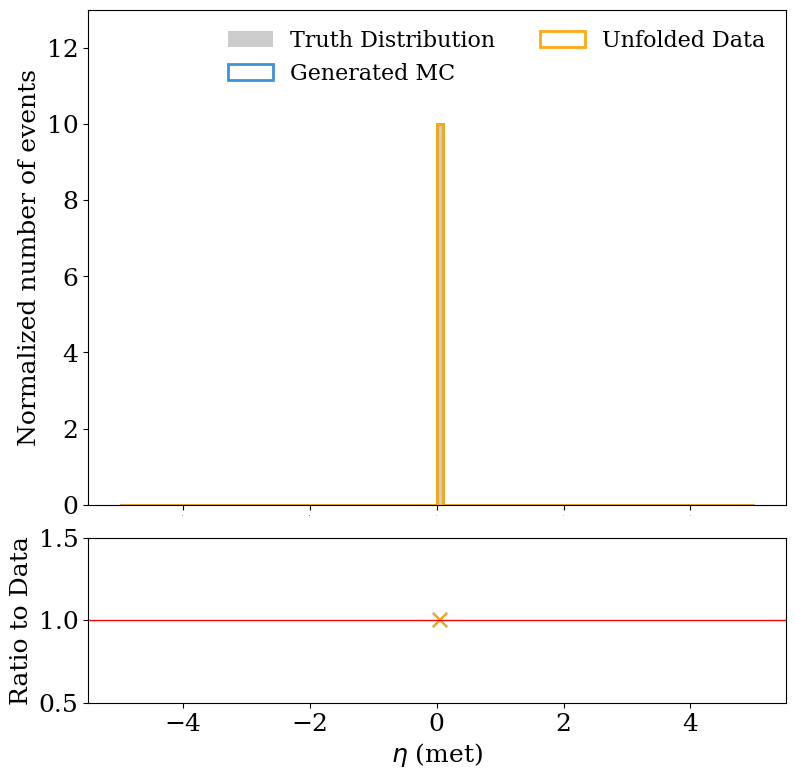

In [18]:
particles = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']

pt_binning = {
    'l1': np.linspace(0, 300, 31),
    'b1': np.linspace(0, 400, 41),
    'b2': np.linspace(0, 300, 31),
    'b3': np.linspace(0, 200, 21),
    'b4': np.linspace(0, 150, 16),
    'j1': np.linspace(0, 500, 51),
    'j2': np.linspace(0, 400, 41),
    'j3': np.linspace(0, 300, 31),
    'j4': np.linspace(0, 250, 26),
    'j5': np.linspace(0, 200, 21),
    'j6': np.linspace(0, 150, 16),
    'met': np.linspace(0, 300, 31),
}
default_binning = [
    None,  # placeholder for pt, unused
    np.linspace(-5, 5, 101),     # eta
]

labels = [
    r"$p_\mathrm{T}$",
    r"$\eta$",
]


for i, pname in enumerate(particles):
    for obs_index in range(2):  # 0: pT, 1: eta
        if obs_index == 0:
            bins = pt_binning[pname]
        else:
            bins = default_binning[obs_index]
        data_dict = {
            'Truth Distribution': herwig_loader.gen[:, i, obs_index][herwig_loader.gen[:, i, 0]!=0],
            #'Reconstructed Data': herwig_loader.reco[:, i, obs_index][herwig_loader.reco[:, i, 0]!=0],
            'Generated MC': pythia_loader.gen[:, i, obs_index][(pythia_loader.gen[:, i, 0]!=0)],
            #'Reconstructed MC': pythia_loader.reco[:, i, obs_index][(pythia_loader.reco[:, i, 0]!=0)],
            'Unfolded Data': pythia_truth_test[:, i, obs_index][pythia_truth_test[:, i, 0]!=0],
        }

        weight_dict = {
            'Truth Distribution': herwig_loader.weight[herwig_loader.gen[:, i, 0]!=0],
            #'Reconstructed Data': herwig_loader.weight[herwig_loader.reco[:, i, 0]!=0],
            'Generated MC': pythia_loader.weight[(pythia_loader.gen[:, i, 0]!=0)],
            #'Reconstructed MC': pythia_loader.weight[(pythia_loader.reco[:, i, 0]!=0)],
            'Unfolded Data': unfolded_weights[pythia_truth_test[:, i, 0]!=0]*pythia_weights_test[pythia_truth_test[:, i, 0]!=0],
        }

        fig, _ = HistRoutine(
            data_dict,
            f"{labels[obs_index]} ({pname})",
            reference_name='Truth Distribution',
            weights=weight_dict,
            plot_ratio=True,
            binning=bins,
        )